# Introduction

This notebook is a PyTorch implementation of the U-Net model from the paper: https://arxiv.org/abs/1505.04597.

It's trained on the dataset from the ISBI-2012 Segmentation Challenge: https://imagej.net/events/isbi-2012-segmentation-challenge.

# U-Net Architecture

![unet](https://miro.medium.com/v2/resize:fit:1400/1*f7YOaE4TWubwaFF7Z1fzNw.png)

In [1]:
import torch
import torch.nn as nn

### Double Convolution

In [2]:
class DoubleConvolution(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConvolution, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0)
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.relu(x)
    return x

### U-Net Model

In [3]:
def crop(input, output_shape):
  n = output_shape[0]
  c = output_shape[1]
  h = output_shape[2]
  w = output_shape[3]

  # Difference between the input shape and output shape
  delta_h = input.shape[2] - h
  delta_w = input.shape[3] - w

  cropped_input = input[:n,
                        :c,
                        delta_h//2:h+delta_h//2,
                        delta_w//2:w+delta_w//2]

  return cropped_input

In [4]:
class UNet(nn.Module):
  def __init__(self, input_channels, output_channels):
    super(UNet, self).__init__()

    # Contracting path
    self.down_conv1 = DoubleConvolution(input_channels, 64)
    self.down_conv2 = DoubleConvolution(64, 128)
    self.down_conv3 = DoubleConvolution(128, 256)
    self.down_conv4 = DoubleConvolution(256, 512)
    self.down_conv5 = DoubleConvolution(512, 1024)
    self.maxpool2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Expansive path
    self.up_conv_t1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    self.up_conv1 = DoubleConvolution(1024, 512)
    self.up_conv_t2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.up_conv2 = DoubleConvolution(512, 256)
    self.up_conv_t3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.up_conv3 = DoubleConvolution(256, 128)
    self.up_conv_t4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.up_conv4 = DoubleConvolution(128, 64)

    # Final layer
    self.final_conv = nn.Conv2d(64, output_channels, kernel_size=1)

  def forward(self, x):
    # Contracting path
    x1 = self.down_conv1(x)

    x2 = self.maxpool2x2(x1)
    x3 = self.down_conv2(x2)

    x4 = self.maxpool2x2(x3)
    x5 = self.down_conv3(x4)

    x6 = self.maxpool2x2(x5)
    x7 = self.down_conv4(x6)

    x8 = self.maxpool2x2(x7)
    x9 = self.down_conv5(x8)

    # Expansive path
    x10 = self.up_conv_t1(x9)
    cropped_down1 = crop(x7, x10.shape)
    x11 = self.up_conv1(torch.cat((cropped_down1, x10), dim=1))

    x12 = self.up_conv_t2(x11)
    cropped_down2 = crop(x5, x12.shape)
    x13 = self.up_conv2(torch.cat((cropped_down2, x12), dim=1))

    x14 = self.up_conv_t3(x13)
    cropped_down3 = crop(x3, x14.shape)
    x15 = self.up_conv3(torch.cat((cropped_down3, x14), dim=1))

    x16 = self.up_conv_t4(x15)
    cropped_down4 = crop(x1, x16.shape)
    x17 = self.up_conv4(torch.cat((cropped_down4, x16), dim=1))

    # Final layer
    out = self.final_conv(x17)

    return out

# Data

In [6]:
def enlarge_image(input, output_size):
  """
  Helper function to enlarge image to target shape.

  Like in the paper, missing input data is extrapolated using mirroring
  (padding_mode='reflect').
  """
  input_size = input.shape[2]
  delta = output_size - input_size
  padding = delta // 2
  return transforms.Pad(padding=padding, padding_mode='reflect')(input)

In [7]:
from skimage import io
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, TensorDataset

In [8]:
import torchvision
import torchvision.transforms as transforms

In [32]:
FILE_DIR = ""

### Training data

In [10]:
volumes = torch.Tensor(io.imread(FILE_DIR + 'train-volume.tif'))[:, None, :, :] / 255
labels = torch.Tensor(io.imread(FILE_DIR + 'train-labels.tif'))[:, None, :, :] / 255

In [11]:
print(volumes.shape)
print(labels.shape)

torch.Size([30, 1, 512, 512])
torch.Size([30, 1, 512, 512])


In [12]:
sample_volume = torch.permute(volumes[0], (1, 2, 0))

In [13]:
sample_label = torch.permute(labels[0], (1, 2, 0))

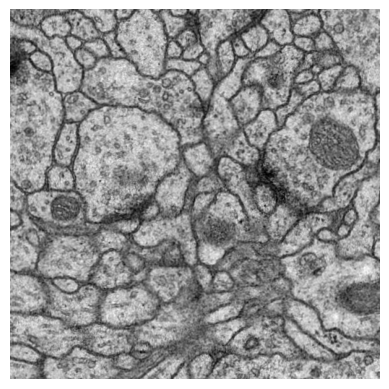

In [14]:
plt.imshow(sample_volume, cmap='gray')
plt.axis('off')
plt.show()

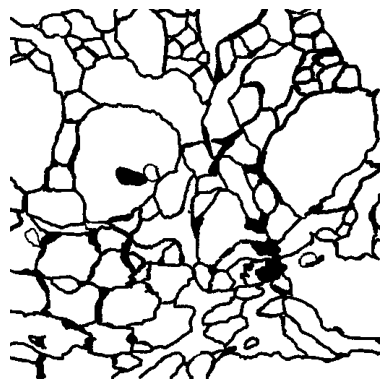

In [15]:
plt.imshow(sample_label, cmap='gray')
plt.axis('off')
plt.show()

In [16]:
batch_size = 4
input_channels = 1
output_channels = 1

# Using the same size as in the paper
input_size = 572
output_size = 388

In [17]:
volumes = enlarge_image(volumes, input_size)
# Labels are size 512x512, so reduce size to match the expected output size of
# 388x388.
labels = crop(labels, torch.Size([len(labels), 1, output_size, output_size]))

dataset = TensorDataset(volumes, labels)

In [18]:
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=True)

### Test data

In [24]:
volumes_test = torch.Tensor(io.imread(FILE_DIR + 'test-volume.tif'))[:, None, :, :] / 255
labels_test = torch.Tensor(io.imread(FILE_DIR + 'test-labels.tif'))[:, None, :, :] / 255

In [25]:
print(volumes_test.shape)
print(labels_test.shape)

torch.Size([30, 1, 512, 512])
torch.Size([30, 1, 512, 512])


In [26]:
volumes_test = enlarge_image(volumes_test, input_size)
test_labels = crop(labels_test, torch.Size([len(labels_test), 1, output_size, output_size]))

test_dataset = TensorDataset(volumes_test, test_labels)

In [27]:
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)

# Training

In [19]:
EPOCHS = 500
lr = 2e-4

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = UNet(input_channels, output_channels)
model.to(device)

In [22]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [23]:
model.train()
for epoch in range(EPOCHS):
  total_loss = 0

  for volumes, labels in dataloader:
    volumes = volumes.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    pred = model(volumes)
    loss = loss_function(pred, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  if (epoch + 1) % 10 == 0:
    print(f"Epoch: {epoch+1} training loss: {total_loss}")

Epoch: 10 training loss: 2.7955572605133057
Epoch: 20 training loss: 2.3792282342910767
Epoch: 30 training loss: 2.255805552005768
Epoch: 40 training loss: 2.0975058525800705
Epoch: 50 training loss: 2.0249790102243423
Epoch: 60 training loss: 1.813024252653122
Epoch: 70 training loss: 1.4921769350767136
Epoch: 80 training loss: 1.3058844059705734
Epoch: 90 training loss: 1.0728921592235565
Epoch: 100 training loss: 0.9349997639656067
Epoch: 110 training loss: 0.7846038490533829
Epoch: 120 training loss: 0.6231277734041214
Epoch: 130 training loss: 0.5191315412521362
Epoch: 140 training loss: 0.4719863682985306
Epoch: 150 training loss: 0.36632926762104034
Epoch: 160 training loss: 0.38626210764050484
Epoch: 170 training loss: 0.2484503537416458
Epoch: 180 training loss: 0.22767764143645763
Epoch: 190 training loss: 0.2398395538330078
Epoch: 200 training loss: 0.20003988966345787
Epoch: 210 training loss: 0.17883248068392277
Epoch: 220 training loss: 0.17939599603414536
Epoch: 230 trai

# Evaluation

In [28]:
from torchvision.utils import make_grid

In [29]:
def show_images(image_tensor, num_images=4, size=(1, 32, 32)):
  """
  Helper function to display images.
  """
  image = image_tensor.detach().cpu().view(-1, *size)
  grid = make_grid(image[:num_images], nrow=4)
  plt.imshow(grid.permute(1, 2, 0).squeeze())
  plt.axis('off')
  plt.show()

Batch # 1
Volumes:


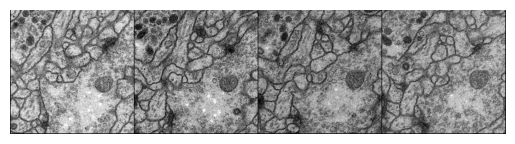

Predictions:


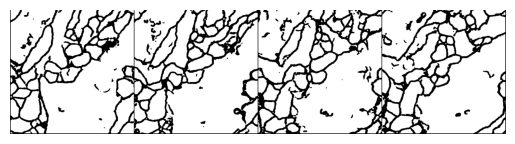

Labels:


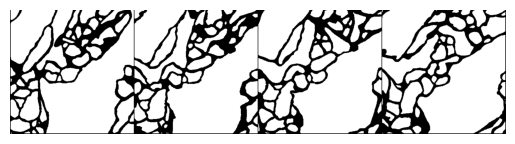

Batch # 2
Volumes:


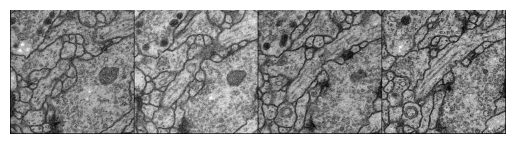

Predictions:


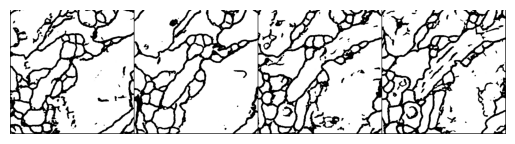

Labels:


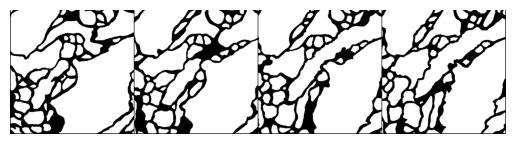

Batch # 3
Volumes:


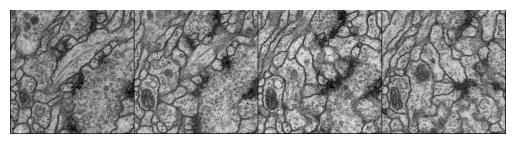

Predictions:


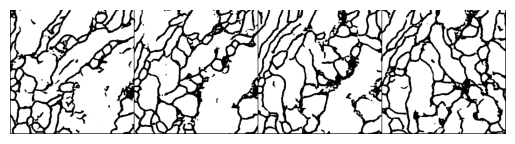

Labels:


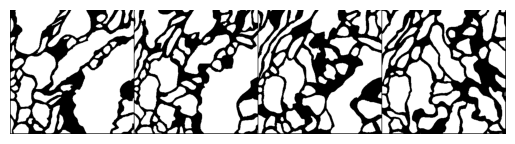

Batch # 4
Volumes:


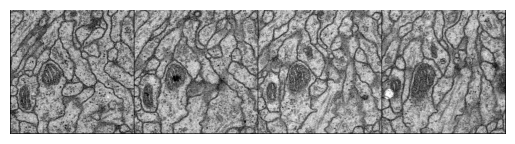

Predictions:


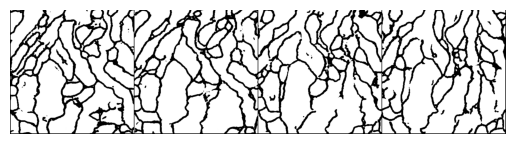

Labels:


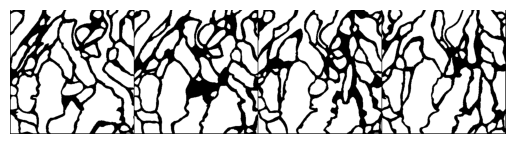

Batch # 5
Volumes:


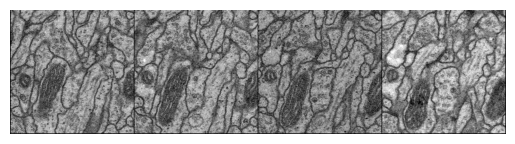

Predictions:


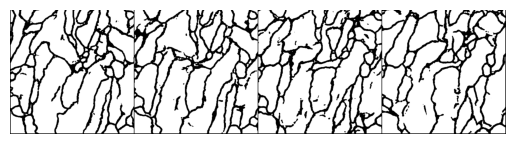

Labels:


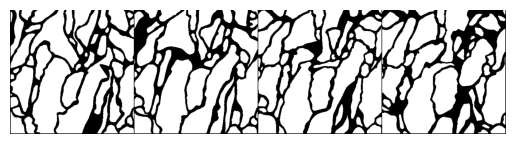

Batch # 6
Volumes:


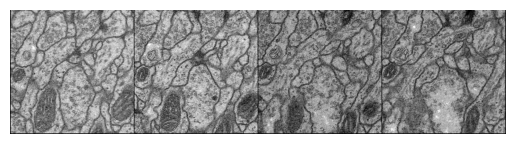

Predictions:


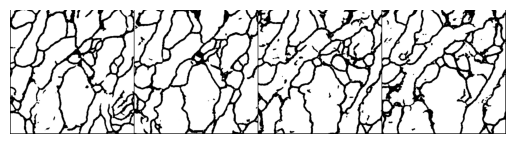

Labels:


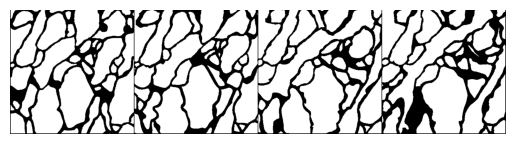

Batch # 7
Volumes:


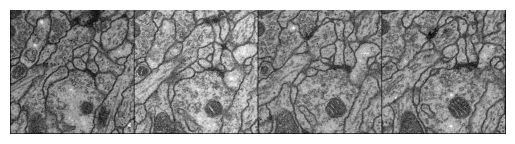

Predictions:


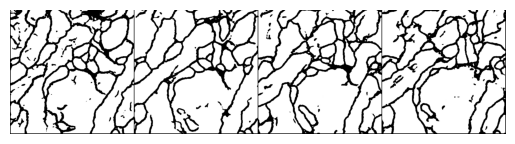

Labels:


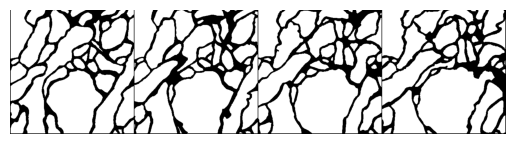

Batch # 8
Volumes:


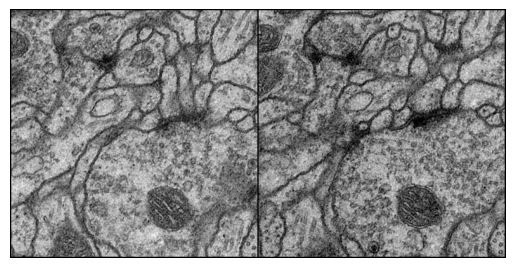

Predictions:


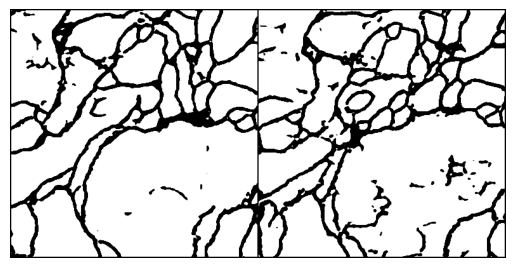

Labels:


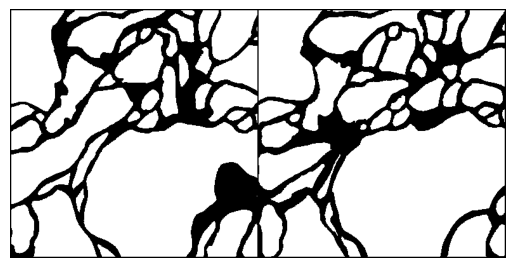

In [30]:
model.eval()
total_loss = 0

for batch_idx, (volumes, labels) in enumerate(test_dataloader):
  volumes = volumes.to(device)
  labels = labels.to(device)

  pred = model(volumes)
  loss = loss_function(pred, labels)

  print("Batch #", batch_idx+1)
  print("Volumes:")
  show_images(crop(volumes, torch.Size([len(volumes), 1, output_size, output_size])),
              size=(input_channels, output_size, output_size))

  print("Predictions:")
  show_images(torch.sigmoid(pred), size=(output_channels, output_size, output_size))

  print("Labels:")
  show_images(labels, size=(output_channels, output_size, output_size))

  total_loss += loss.item()

In [31]:
print("Average test loss:", total_loss / len(test_dataloader))

Average test loss: 5.6154351234436035
